# Setup: Create Data

In [44]:
# from src.cone_model import HEALPixCone

# data_NSIDE = 32

# cone_model = HEALPixCone(
#         output_dir=os.path.join("", 'figs'),
#         NSIDE=data_NSIDE
# )

# train_dset = cone_model.create_dataset(dataset_size=1024)
# val_dset = cone_model.create_dataset(dataset_size=1024)   
# f = open(f"sphere_datasets_NSIDE{config.NSIDE}.pkl", "wb"); pickle.dump((train_dset, val_dset), f); f.close()

# Set Important Parameters

In [45]:
NSIDE = 32
NUMPIX = 12 * NSIDE ** 2
DEPTH = 4
SHOW_IMAGES = True

# Helper Functions

In [46]:
from torchvision.utils import save_image
import os
import torch

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device


def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 12 * NSIDE // 8, 64 * NSIDE // 8)
    save_image(img, name)

Set Device.

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
base = torch.float32

#pin to gpu
device

device(type='cpu')

Set Seed for Pytorch

In [48]:
from src.utils import set_seed
set_seed(2021)

# 1. Load in Data

In [49]:
'''
Open the file.
'''

import pickle
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

file_name = f"sphere_datasets_NSIDE{NSIDE}.pkl"

f = open(file_name, "rb")
train_dset, val_dset = pickle.load(f)
f.close()

test = np.array(train_dset)

print(len(train_dset), len(val_dset))

1024 1024


# 2. Reshape Data into Rectangles

In [50]:
'''

Create the training and validation datasets. Do any necessary reshaping. 

'''

import numpy as np


y_combined = []

# NOTE: Can change based on input size of data
# For now, default to 12, 64 size for NSIDE 8 that is scaled up for larger NSIDEs. 
length = 64 * NSIDE // 8
width = 12 * NSIDE // 8
rect_shape = (1, width, length)

NUM_CHANNELS = 1

for i in range(len(train_dset)):
    all_train_depths = train_dset[i]['label'].reshape(NUM_CHANNELS, DEPTH, NUMPIX)
    all_val_depths = val_dset[i]['label'].reshape(NUM_CHANNELS, DEPTH, NUMPIX)

    # [0] just so you can get inside the list (only one channel)
    for j in range(4):
        y_combined.append(all_train_depths[0][j].reshape(rect_shape))
        y_combined.append(all_val_depths[0][j].reshape(rect_shape))

y_combined = np.array(y_combined)

print("y_combined shape: ", y_combined.shape)



y_combined shape:  (8192, 1, 48, 256)


# 3. Split Data into Train, Val, Test

In [51]:
train_len = int(0.8 * len(y_combined)) # 70%
val_len = int(0.15 * len(y_combined)) - train_len # 15%
test_len = len(y_combined) - train_len - val_len # 15%

y_train = y_combined[:train_len]
y_val = y_combined[:val_len]
y_test = y_combined[:test_len]

print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (6553, 1, 48, 256)
y_val shape:  (2867, 1, 48, 256)
y_test shape:  (6964, 1, 48, 256)


# 3. Create Noisy Versions of Data

In [52]:
mu, sigma = 0, 0.3 # mu is the mean, sigma is the standard deviation of the noise distribution

x_combined = []

noise_shape = rect_shape

for y_sample in y_combined:
    # Create array of noise of how many pixels there are
    noise = np.random.normal(mu, sigma, noise_shape)

    x_combined.append(y_sample + noise)

x_combined = np.array(x_combined)

print("x_combined shape: ", x_combined.shape)


x_combined shape:  (8192, 1, 48, 256)


# 4. Create Test, Val, and Train

In [53]:
train_len = int(0.8 * len(y_combined)) # 70%
val_len = int(0.15 * len(y_combined)) - train_len # 15%
test_len = len(y_combined) - train_len - val_len # 15%

y_train = y_combined[:train_len]
y_val = y_combined[:val_len]
y_test = y_combined[:test_len]

x_train = x_combined[:train_len]
x_val = x_combined[:val_len]
x_test = x_combined[:test_len]

print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)
print()
print("x_train shape: ", x_train.shape)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)

y_train shape:  (6553, 1, 48, 256)
y_val shape:  (2867, 1, 48, 256)
y_test shape:  (6964, 1, 48, 256)

x_train shape:  (6553, 1, 48, 256)
x_val shape:  (2867, 1, 48, 256)
x_test shape:  (6964, 1, 48, 256)


### Print sample of the noisy healpix data vs. actual data.

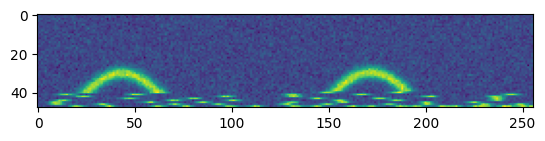

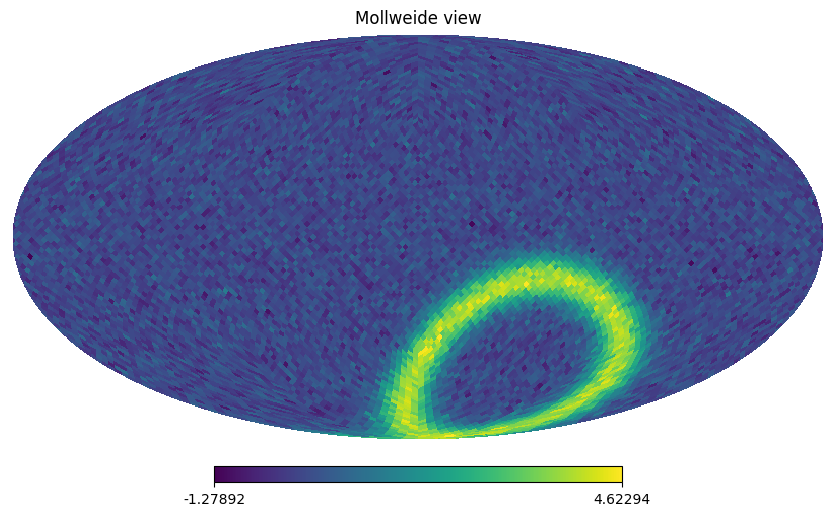

In [54]:
NUM = 333

# [0] since 1 channel
sample_x = x_train[NUM][0]
sample_y = y_train[NUM][0]

if SHOW_IMAGES:
    plt.imshow(sample_x)
    hp.mollview(sample_x.reshape(NUMPIX))


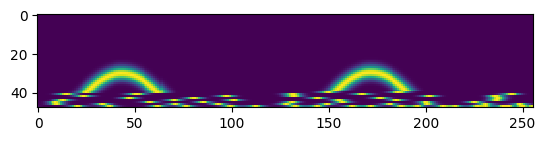

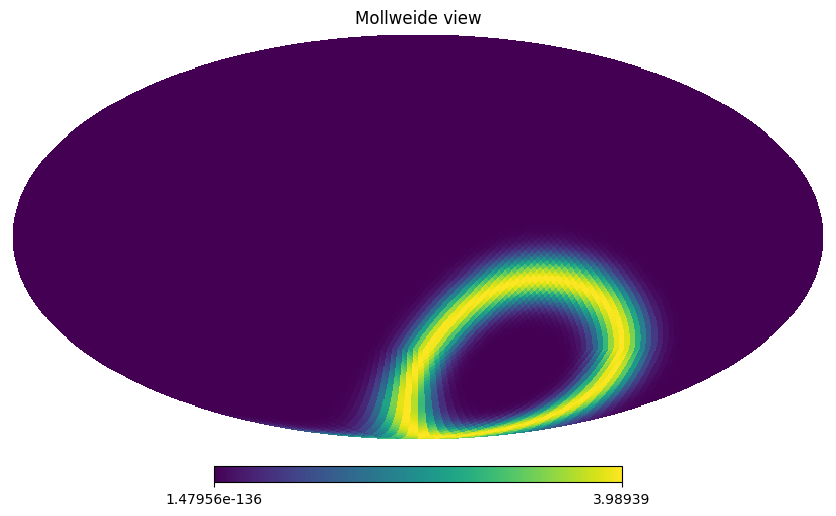

In [55]:
if SHOW_IMAGES:
    plt.imshow(sample_y, interpolation='nearest')
    hp.mollview(sample_y.reshape(NUMPIX))

# 5. Create Dataset and DataLoader

Dataset is wrapper for data with labels, DataLoader is wrapper around that in iterable form.

In [56]:
# constants
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
BATCH_SIZE = 32 # previously 1
NOISE_FACTOR = 0.5

In [57]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

# class GammaDataset(Dataset):
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y

#     def __len__(self):
#         return len(self.x)
    
#     def __getitem__(self, index):
#         return self.x[index], self.y[index]

# train_set = GammaDataset(x_train.to, y_train)
# val_set = GammaDataset(x_val, y_val)
# test_set = GammaDataset(x_test, y_test)

# the "to(torch.float32) is to make it compatible with cpu. We want base 32."

train_set = TensorDataset(torch.tensor(x_train).to(dtype=base, device=device), torch.tensor(y_train).to(dtype=base, device=device))
val_set = TensorDataset(torch.tensor(x_val).to(dtype=base, device=device), torch.tensor(y_val).to(dtype=base, device=device))
test_set = TensorDataset(torch.tensor(x_test).to(dtype=base, device=device), torch.tensor(y_test).to(dtype=base, device=device))

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=True)

Verify the arrays are of the right type (base 32).

In [58]:
# for val in train_loader:
#     tens = val[0]
#     print(tens.dtype)

el = train_set[0][0][0]
el.dtype

torch.float32

# 6. Create Autoencoder

In [59]:
from torch.nn import Module, Conv2d, Sequential, ConvTranspose2d, ReLU, MaxPool2d


'''

IMPORTANT: out_channels is how many filters will be learned for that layer in training
--> the feature map for that layer (3D thing of what the layer outputs) is the stack of these channels (filters) 

'''


class AutoEncoder(Module): 
    def __init__(self, IN_CHANNELS, encoder, decoder):
        super().__init__()

        # Put encoder layers in Sequential container
        # First increase from 1 --> 64 channels
        # Keep decreasing number of channels
        
        self.encoder = encoder

        self.decoder = decoder

    # Run x through each layer
    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        
        for layer in self.decoder:
            x = layer(x)
        
        return x
        

In [60]:
IN_CHANNELS = NUM_CHANNELS # Not RGB, just one value for each pixel. Healpy just adds color by itself. 


model8_enc = Sequential(
            Conv2d(IN_CHANNELS, 64, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(64, 32, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(32, 16, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(16, 8, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(2, 2),
    )

model8_dec = Sequential(
            ConvTranspose2d(8, 16, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(16, 32, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(32, 64, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            ReLU()
    )

# model for NSIDE=8
model8 = AutoEncoder(IN_CHANNELS, model8_enc, model8_dec).to(dtype=base, device=device)
print(model8)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
  )
)


In [61]:
IN_CHANNELS = 1 # Not RGB, just one value for each pixel. Healpy just adds color by itself. 

model32_enc = Sequential(
            Conv2d(IN_CHANNELS, 64, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(64, 32, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(32, 16, kernel_size=3, padding=1),
            ReLU(),
            Conv2d(16, 8, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(2, 2),
    )

model32_dec = Sequential(
            ConvTranspose2d(8, 16, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(16, 32, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(32, 64, kernel_size=1, stride=1),
            ReLU(),
            ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            ReLU()
    )

# model for NSIDE=8
model32 = AutoEncoder(IN_CHANNELS, model32_enc, model32_dec).to(dtype=base, device=device)
print(model32)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
  )
)


Pick which model to use.

In [62]:
model = model32

# 7. Create Trainer

In [63]:
import torch.optim as optim
from torch.nn import MSELoss

# Use MSE Loss
# need to specify cpu
criterion = MSELoss().to(dtype=base, device=device)

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [64]:


train_loss_hist = []
val_loss_hist = []
epoch = 0

def train(model, train_loader, NUM_EPOCHS):
    global train_loss_hist
    global val_loss_hist
    global epoch

    while epoch < NUM_EPOCHS:
        running_loss = 0.0

        # Go through each batch of the data (can pass in entire batch at once!)
        # batch - number of training examples for one forward/backward pass. So pass in batch data values then update weights. 
        for batch in train_loader:
            # Remember, it's in batches. 
            x_vals, y_vals = batch
            
            '''

            Reset gradients to 0 so updating of weights can be done correctly.

            When we do loss.backward(), gradients are calculated. Then, optimizer.step() does gradient descent.
            For the next batch, we don't want these gradients to still be lingering (because a new input will have new gradients).
            Thus, we have to reset the gradients to 0. 

            NOTE: This is not the same as setting the weights to 0! We are just resetting the calculated gradients.
            
            '''
            optimizer.zero_grad()

            # Calculate model outputs
            outputs = model(x_vals)

            # Calculate loss
            loss = criterion(outputs, y_vals)

            # Calculate gradients 
            loss.backward()

            # Do gradient descent to update the weights.
            optimizer.step()

            running_loss += loss.item()


        loss = running_loss / len(train_loader)
        train_loss_hist.append(loss)


        running_val_loss = 0.0
        # Calculate val loss
        for x, y in val_loader:
            optimizer.zero_grad()
            
            # Calculate model outputs
            val_outputs = model(x)

            loss = criterion(val_outputs, y)
            running_val_loss += loss

        val_loss = running_val_loss / len(val_loader)
        val_loss_hist.append(val_loss)


        print(f'Epoch {epoch + 1} of {NUM_EPOCHS}, Train Loss: {loss}, Val Loss: {val_loss}')
        # print(f'Epoch {epoch + 1} of {NUM_EPOCHS}, Train Loss: {loss}')

        if epoch % 2 == 0:
            save_decoded_image(x_vals.cpu().data, name='./Saved_Images/noisy{}.png'.format(epoch))
            save_decoded_image(outputs.cpu().data, name='./Saved_Images/denoised{}.png'.format(epoch))
        
        epoch += 1

# Train Model

In [65]:
train(model, train_loader, NUM_EPOCHS)

KeyboardInterrupt: 

# Check Performance

In [ ]:
def eval_performance(model, data_loader):
    total_loss = 0.0
    for x, y in data_loader:
        pred = model(x)

        total_loss += criterion(pred, y)
        
    return total_loss / len(data_loader)


print(eval_performance(model, val_loader))


In [ ]:

def display_sample(model, data_loader):
    for x, y in data_loader:
        pred = model(x)
        
        # [0] because 1 channel so need to go inside
        hp.mollview(torch.reshape(x[0], (NUMPIX, )))
        hp.mollview(torch.reshape(y[0], (NUMPIX, )))
        hp.mollview(np.reshape(pred[0].detach().numpy(), (NUMPIX, )))
        break
    
if SHOW_IMAGES:
    display_sample(model, val_loader)

# Save Model

In [ ]:
final_train_loss = round(float(train_loss_hist[-1]), 3)
final_val_loss = round(float(val_loss_hist[-1]), 3)

name = f"saved_models/model_NSIDE{NSIDE}_trainloss{final_train_loss}_valloss{final_val_loss}_epochs{epoch}.pth"

torch.save(model.state_dict(), name)